## Exploratory Data Analysis (EDA): Rent Growth & Vacancy

This notebook explores the historical rental market behavior to inform scenario assumptions (Bear/Base/Bull) used in the residential investment financial model. 

The objective is to: 
- Understand the distribution of rent growth 
- Identify downside and upside risk 
- Calibrate scenario assumptions using empirical data 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [43]:
path = "../data/raw/abs_cpi_rents.csv"
raw = pd.read_csv(path, skiprows=1) #header row is not needed 
raw.head(20)

,Unnamed: 0,Annual (RHS) (%),Monthly (LHS) (%)
0,Sep-22,2.9,0.5
1,Oct-22,3.5,0.6
2,Nov-22,3.6,0.2
3,Dec-22,4.1,0.5
4,Jan-23,4.8,0.7
5,Feb-23,4.8,0.7
6,Mar-23,5.3,0.5
7,Apr-23,6.1,0.8
8,May-23,6.3,0.8
9,Jun-23,7.3,0.9


In [20]:
raw.columns

Index(['Unnamed: 0', 'Annual (RHS) (%)', 'Monthly (LHS) (%)'], dtype='object')

## Data Description 

Expected structure: 
- Date: Monthly or quarterly timestamp 
- Rate Index or Rent: level series 
- Vacancy Rate: percentage

Transformation: 
- Convert level series to year-on-year (YoY) growth 
- Cleaning of raw data, aligning frequency and handling any missing values 

In [29]:
#Standardising the dataframe to two columns (date and rent_growth_yoy)

# Standardise the dataframe to two columns (date and rent_growth_yoy)
df = raw.rename(columns={raw.columns[0]: "Date","Annual (RHS) (%)": "rent_growth_yoy"})[["Date", "rent_growth_yoy"]].copy()

df["Date"] = pd.to_datetime(df["Date"], format="%b-%y", errors="coerce")

df["rent_growth_yoy"] = pd.to_numeric(df["rent_growth_yoy"], errors="coerce") / 100.0 #convert % to decimal

df = df.dropna(subset=["Date", "rent_growth_yoy"]).sort_values("Date").reset_index(drop=True)

df.head(10)

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048
5,2023-02-01,0.048
6,2023-03-01,0.053
7,2023-04-01,0.061
8,2023-05-01,0.063
9,2023-06-01,0.073


## Exploratory Analysis Plan 

1. Visualise distribution of rent growth 
2. Identify downside and upside tails 
3. Compute summary statistics: 
    - Mean 
    - Median 
    - Standard Deviation 
    - 10th / 50th / 90th percentiles 
4. Map percentiles to Bear / Base / Bull assumptions 

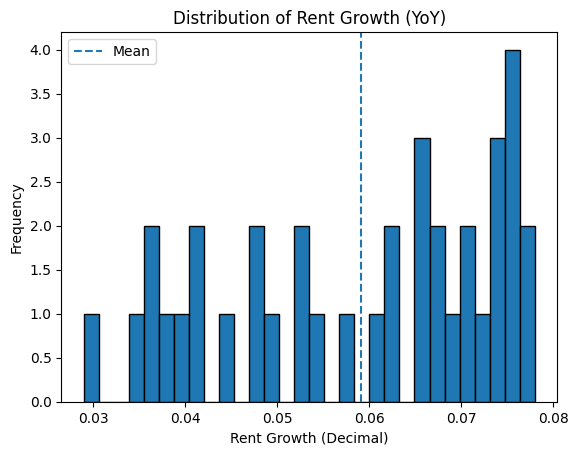

In [37]:
#Plotting histogram 
plt.figure()
plt.hist(df["rent_growth_yoy"], bins=30, edgecolor="black")
plt.axvline(df["rent_growth_yoy"].mean(), linestyle="--",label="Mean")
plt.title("Distribution of Rent Growth (YoY)")
plt.xlabel("Rent Growth (Decimal)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [40]:
#Summary Statistics & Percentiles 

p10, p50,p90 = np.percentile(df["rent_growth_yoy"],[10,50,90])

summary = pd.DataFrame({
    "Statistics": ["Mean","Base (50th Percentile)","Bear (10th Percentile)","Bull (90th Percentile)", "Std Dev"],
    "Rent Growth": [
        df["rent_growth_yoy"].mean(),
        p50,
        p10,
        p90,
        df["rent_growth_yoy"].std()
    ]
})

summary

,Statistics,Rent Growth
0,Mean,0.059162
1,Base (50th Percentile),0.063000
2,Bear (10th Percentile),0.037600
3,Bull (90th Percentile),0.076000
4,Std Dev,0.014861


## Scenario Calibration 

Based on historical distribution of YoY rent growth: 
- Bear case = 0.0376 (10th percentile)
- Base case = 0.0630 (50th percentile/median)
- Bull case = 0.0760 (90th percentile)

These values are used directly in the rent growth assumption in the financial model. 

In [44]:
summary.to_csv("../outputs/rent_growth_percentiles.csv",index=False)